In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Plot Loss and Accuracy Curves

In [2]:
import re
def get_epoch_num(epoch_string, suppress = True):
    try:
        results_list = re.findall("(?<=\[).*?(?=\])", epoch_string)
        epoch_num = float(results_list[0])
    except:
        if not(suppress):
            print("Epoch num failed: " + str(epoch_string))
        epoch_num = np.nan
    return epoch_num

def get_minibatch_num(epoch_string, suppress = True):
    try:
        results_list = re.findall("(?<=\[).*?(?=\])", epoch_string)
        minibatch_num = results_list[1]
    except:
        if not(suppress):
            print("Minibatch num failed: " + str(epoch_string))
        minibatch_num = np.nan
    return minibatch_num

def get_lr(epoch_string, suppress = True):
    try:
        results_list = epoch_string.split("lr: ")
        lr = float(results_list[-1])
    except:
        if not(suppress):
            print("lr failed: " + str(epoch_string))
        lr = np.nan
    return lr

def parse_train_string_n(in_string, n, suppress = True):
    try:
        results_list = in_string.split("(")
        train_string = results_list[0]
        proc_train_string = train_string[n:]
        final_train_string = float(proc_train_string[:-1])
    except:
        if not(suppress):
            print("Train string n failed: " + str(in_string))
        final_train_string = np.nan
    return final_train_string

def parse_val_string(in_string, suppress = True):
    try:
        results_list = in_string.split("(")
        val_string = results_list[1]
        val_string = float(val_string[:-1])
    except:
        if not(suppress):
            print("Val string n failed: " + str(in_string))
        val_string = np.nan
    return val_string

def preparse_result_df(file_name, suppress_val = True):
    result_tab = pd.read_table(file_name, header = None, names = ["Epoch_String", "Time_String", "Data_String", "Loss_String", "Prec1_String", "Prec5_String"])

    result_tab["Epoch"] = result_tab["Epoch_String"].apply(lambda epoch_string: get_epoch_num(epoch_string, suppress=suppress_val))
    result_tab["Minibatch"] = result_tab["Epoch_String"].apply(lambda epoch_string: get_minibatch_num(epoch_string, suppress=suppress_val))
    result_tab["lr"] = result_tab["Epoch_String"].apply(lambda epoch_string: get_lr(epoch_string, suppress=suppress_val))
    result_tab["Time_Train"] = result_tab["Time_String"].apply(lambda time_string: parse_train_string_n(time_string, 5, suppress = suppress_val))
    result_tab["Time_Avg"] = result_tab["Time_String"].apply(lambda time_string: parse_val_string(time_string, suppress = suppress_val))
    result_tab["Data_Train"] = result_tab["Data_String"].apply(lambda data_string: parse_train_string_n(data_string, 5, suppress = suppress_val))
    result_tab["Data_Avg"] = result_tab["Data_String"].apply(lambda data_string: parse_val_string(data_string, suppress = suppress_val))
    result_tab["Loss_Train"] = result_tab["Loss_String"].apply(lambda loss_string: parse_train_string_n(loss_string, 5, suppress = suppress_val))
    result_tab["Loss_Avg"] = result_tab["Loss_String"].apply(lambda loss_string: parse_val_string(loss_string, suppress = suppress_val))
    result_tab["Prec1_Train"] = result_tab["Prec1_String"].apply(lambda prec1_string: parse_train_string_n(prec1_string, 7, suppress = suppress_val))
    result_tab["Prec1_Avg"] = result_tab["Prec1_String"].apply(lambda prec1_string: parse_val_string(prec1_string, suppress = suppress_val))
    result_tab["Prec5_Train"] = result_tab["Prec5_String"].apply(lambda prec5_string: parse_train_string_n(prec5_string, 7, suppress = suppress_val))
    result_tab["Prec5_Avg"] = result_tab["Prec5_String"].apply(lambda prec5_string: parse_val_string(prec5_string, suppress = suppress_val))

    return result_tab

def postprocess_result_df(result_df, parsed_columns_only = False):
    final_indices = result_df["Epoch_String"].str.contains("Epoch: ")
    final_indices = final_indices.fillna(False)
    
    if (parsed_columns_only):
        final_columns = ["Epoch", "Minibatch", "lr", "Time_Train", "Time_Val", "Data_Train", "Data_Val", "Loss_Train", "Loss_Val", "Prec1_Train", "Prec1_Val", "Prec5_Train", "Prec5_Val"]
        result_df = result_df[final_columns]
    
    return result_df[final_indices]

def parse_test_df_row(row):
    epoch_string = row["Epoch_String"]
    list1 = epoch_string.split("Testing Results: Prec@1 ")
    list2 = list1[1].split(" Prec@5 ")
    prec1 = list2[0]
    list3 = list2[1].split(" Loss ")
    prec5 = list3[0]
    loss = list3[1]
    
    row["Prec1"] = float(prec1)
    row["Prec5"] = float(prec5)
    row["Loss"] = float(loss)
    
    return row
    
def parse_test_df(result_tab):
    test_indices = result_tab["Epoch_String"].str.contains("Testing Results")
    test_indices = test_indices.fillna(False)

    test_df_initial_columns = ["Epoch_String", "Time_String", "Data_String", "Loss_String", "Prec1_String"]
    test_df = result_tab[test_indices]
    test_df = test_df[test_df_initial_columns]
    test_df["Epoch"] = test_df.index.map(lambda index: result_tab.loc[index + 2, "Epoch"])
    
    final_columns = ["Epoch_String", "Epoch", "Prec1", "Prec5", "Loss"]
    test_df = test_df.apply(parse_test_df_row, axis = 1)
    test_df = test_df[final_columns]
    return test_df

In [3]:
def plot_line_plot(inp_xs, inp_ys, labels, x_label, y_label, title, figsize = (14, 6), font_size = 20):
    fig = plt.figure(figsize = figsize)
    for x, y, label in zip(inp_xs, inp_ys, labels):
        plt.plot(x, y, label = label)
    plt.xlabel(x_label, fontsize = font_size)
    plt.ylabel(y_label, fontsize = font_size)
    plt.title(title, fontsize = font_size)
    plt.tick_params(axis='both', which='major', labelsize=font_size)
    plt.tick_params(axis='both', which='minor', labelsize=font_size)    
    plt.legend(loc='upper right', fontsize = font_size)
    return None

    

In [27]:
result_df

,Epoch_String,Time_String,Data_String,Loss_String,Prec1_String,Prec5_String,Epoch,Minibatch,lr,Time_Train,Time_Avg,Data_Train,Data_Avg,Loss_Train,Loss_Avg,Prec1_Train,Prec1_Avg,Prec5_Train,Prec5_Avg
0,"Epoch: [0][0/16], lr: 0.00100",Time 9.259 (9.259),Data 2.006 (2.006),Loss 5.2973 (5.2973),Prec@1 1.562 (1.562),Prec@5 3.125 (3.125),0.0,0/16,0.00100,9.259,9.259,2.006,2.006,5.2973,5.2973,1.562,1.562,3.125,3.125
1,"Epoch: [1][0/16], lr: 0.00100",Time 3.496 (3.496),Data 3.175 (3.175),Loss 5.2983 (5.2983),Prec@1 0.000 (0.000),Prec@5 4.688 (4.688),1.0,0/16,0.00100,3.496,3.496,3.175,3.175,5.2983,5.2983,0.000,0.000,4.688,4.688
2,"Epoch: [2][0/16], lr: 0.00100",Time 3.845 (3.845),Data 3.525 (3.525),Loss 5.2893 (5.2893),Prec@1 3.125 (3.125),Prec@5 9.375 (9.375),2.0,0/16,0.00100,3.845,3.845,3.525,3.525,5.2893,5.2893,3.125,3.125,9.375,9.375
3,"Epoch: [3][0/16], lr: 0.00100",Time 3.942 (3.942),Data 3.622 (3.622),Loss 5.2942 (5.2942),Prec@1 1.562 (1.562),Prec@5 4.688 (4.688),3.0,0/16,0.00100,3.942,3.942,3.622,3.622,5.2942,5.2942,1.562,1.562,4.688,4.688
4,"Epoch: [4][0/16], lr: 0.00100",Time 3.450 (3.450),Data 3.061 (3.061),Loss 5.2961 (5.2961),Prec@1 0.000 (0.000),Prec@5 1.562 (1.562),4.0,0/16,0.00100,3.450,3.450,3.061,3.061,5.2961,5.2961,0.000,0.000,1.562,1.562
8,"Epoch: [5][0/16], lr: 0.00100",Time 3.515 (3.515),Data 3.196 (3.196),Loss 5.2927 (5.2927),Prec@1 0.000 (0.000),Prec@5 1.562 (1.562),5.0,0/16,0.00100,3.515,3.515,3.196,3.196,5.2927,5.2927,0.000,0.000,1.562,1.562
9,"Epoch: [6][0/16], lr: 0.00100",Time 3.744 (3.744),Data 3.410 (3.410),Loss 5.2942 (5.2942),Prec@1 1.562 (1.562),Prec@5 4.688 (4.688),6.0,0/16,0.00100,3.744,3.744,3.410,3.410,5.2942,5.2942,1.562,1.562,4.688,4.688
10,"Epoch: [7][0/16], lr: 0.00100",Time 3.840 (3.840),Data 3.503 (3.503),Loss 5.2891 (5.2891),Prec@1 4.688 (4.688),Prec@5 6.250 (6.250),7.0,0/16,0.00100,3.840,3.840,3.503,3.503,5.2891,5.2891,4.688,4.688,6.250,6.250
11,"Epoch: [8][0/16], lr: 0.00100",Time 3.463 (3.463),Data 3.113 (3.113),Loss 5.2790 (5.2790),Prec@1 3.125 (3.125),Prec@5 9.375 (9.375),8.0,0/16,0.00100,3.463,3.463,3.113,3.113,5.2790,5.2790,3.125,3.125,9.375,9.375
12,"Epoch: [9][0/16], lr: 0.00100",Time 3.726 (3.726),Data 3.372 (3.372),Loss 5.2756 (5.2756),Prec@1 1.562 (1.562),Prec@5 7.812 (7.812),9.0,0/16,0.00100,3.726,3.726,3.372,3.372,5.2756,5.2756,1.562,1.562,7.812,7.812


In [35]:
result_df

,Epoch_String,Time_String,Data_String,Loss_String,Prec1_String,Prec5_String,Epoch,Minibatch,lr,Time_Train,Time_Avg,Data_Train,Data_Avg,Loss_Train,Loss_Avg,Prec1_Train,Prec1_Avg,Prec5_Train,Prec5_Avg
0,"Epoch: [0][0/16], lr: 0.00100",Time 9.259 (9.259),Data 2.006 (2.006),Loss 5.2973 (5.2973),Prec@1 1.562 (1.562),Prec@5 3.125 (3.125),0.0,0/16,0.00100,9.259,9.259,2.006,2.006,5.2973,5.2973,1.562,1.562,3.125,3.125
1,"Epoch: [1][0/16], lr: 0.00100",Time 3.496 (3.496),Data 3.175 (3.175),Loss 5.2983 (5.2983),Prec@1 0.000 (0.000),Prec@5 4.688 (4.688),1.0,0/16,0.00100,3.496,3.496,3.175,3.175,5.2983,5.2983,0.000,0.000,4.688,4.688
2,"Epoch: [2][0/16], lr: 0.00100",Time 3.845 (3.845),Data 3.525 (3.525),Loss 5.2893 (5.2893),Prec@1 3.125 (3.125),Prec@5 9.375 (9.375),2.0,0/16,0.00100,3.845,3.845,3.525,3.525,5.2893,5.2893,3.125,3.125,9.375,9.375
3,"Epoch: [3][0/16], lr: 0.00100",Time 3.942 (3.942),Data 3.622 (3.622),Loss 5.2942 (5.2942),Prec@1 1.562 (1.562),Prec@5 4.688 (4.688),3.0,0/16,0.00100,3.942,3.942,3.622,3.622,5.2942,5.2942,1.562,1.562,4.688,4.688
4,"Epoch: [4][0/16], lr: 0.00100",Time 3.450 (3.450),Data 3.061 (3.061),Loss 5.2961 (5.2961),Prec@1 0.000 (0.000),Prec@5 1.562 (1.562),4.0,0/16,0.00100,3.450,3.450,3.061,3.061,5.2961,5.2961,0.000,0.000,1.562,1.562
8,"Epoch: [5][0/16], lr: 0.00100",Time 3.515 (3.515),Data 3.196 (3.196),Loss 5.2927 (5.2927),Prec@1 0.000 (0.000),Prec@5 1.562 (1.562),5.0,0/16,0.00100,3.515,3.515,3.196,3.196,5.2927,5.2927,0.000,0.000,1.562,1.562
9,"Epoch: [6][0/16], lr: 0.00100",Time 3.744 (3.744),Data 3.410 (3.410),Loss 5.2942 (5.2942),Prec@1 1.562 (1.562),Prec@5 4.688 (4.688),6.0,0/16,0.00100,3.744,3.744,3.410,3.410,5.2942,5.2942,1.562,1.562,4.688,4.688
10,"Epoch: [7][0/16], lr: 0.00100",Time 3.840 (3.840),Data 3.503 (3.503),Loss 5.2891 (5.2891),Prec@1 4.688 (4.688),Prec@5 6.250 (6.250),7.0,0/16,0.00100,3.840,3.840,3.503,3.503,5.2891,5.2891,4.688,4.688,6.250,6.250
11,"Epoch: [8][0/16], lr: 0.00100",Time 3.463 (3.463),Data 3.113 (3.113),Loss 5.2790 (5.2790),Prec@1 3.125 (3.125),Prec@5 9.375 (9.375),8.0,0/16,0.00100,3.463,3.463,3.113,3.113,5.2790,5.2790,3.125,3.125,9.375,9.375
12,"Epoch: [9][0/16], lr: 0.00100",Time 3.726 (3.726),Data 3.372 (3.372),Loss 5.2756 (5.2756),Prec@1 1.562 (1.562),Prec@5 7.812 (7.812),9.0,0/16,0.00100,3.726,3.726,3.372,3.372,5.2756,5.2756,1.562,1.562,7.812,7.812


In [61]:
def plot_loss_graph(result_df, test_df):
    train_loss = result_df["Loss_Train"].values
    train_epochs = np.array(range(0, len(train_loss)))/(len(train_loss)/result_df["Epoch"].max())
    
    val_loss = test_df["Loss"].values
    val_epochs = test_df["Epoch"].values

    plot_line_plot(inp_xs = [train_epochs, val_epochs],
                  inp_ys = [train_loss, val_loss],
                  labels = ["Train", "Val"],
                  x_label = "Epochs",
                  y_label = "Loss",
                  title = "Loss",
                  figsize = (14, 6),
                  font_size = 20)
    return None

In [62]:
def plot_acc_graph(result_df, test_df):
    train_prec1 = result_df["Prec1_Train"].values
    train_prec5 = result_df["Prec5_Train"].values
    train_epochs = np.array(range(0, len(train_prec1)))/(len(train_prec1)/result_df["Epoch"].max())

    val_prec1 = test_df["Prec1"].values
    val_prec5 = test_df["Prec5"].values
    val_epochs = test_df["Epoch"].values

    xs = [train_epochs, train_epochs, val_epochs, val_epochs]
    ys = [train_prec1, train_prec5, val_prec1, val_prec5]
    labels = ["Train Prec1", "Train Prec5", "Val Prec1", "Val Prec5"]
    
    plot_line_plot(inp_xs = xs,
                  inp_ys = ys,
                  labels = labels,
                  x_label = "Epochs",
                  y_label = "Accuracy (%)",
                  title = "Accuracy",
                  figsize = (14, 6),
                  font_size = 20)
    
    return None

In [63]:
def plot_loss_acc(file_name):
    result_df = preparse_result_df(file_name)
    test_df = parse_test_df(result_df)
    result_df = postprocess_result_df(result_df)
    
    plot_loss_graph(result_df, test_df)
    plot_acc_graph(result_df, test_df)
    
    print("Best Train Loss: " + str(result_df["Loss_Train"].min()))
    print("Best Train Prec1: " + str(result_df["Prec1_Train"].max()))
    print("Best Train Prec5: " + str(result_df["Prec5_Train"].max()))
    print("Best Val Loss: " + str(test_df["Loss"].min()))
    print("Best Val Prec1: " + str(test_df["Prec1"].max()))
    print("Best Val Prec5: " + str(test_df["Prec5"].max()))
    
    print("")
    print(result_df["Loss_Train"].min())
    print(result_df["Prec1_Train"].max())
    print(result_df["Prec5_Train"].max())
    print(test_df["Loss"].min())
    print(test_df["Prec1"].max())
    print(test_df["Prec5"].max())
    
    return result_df, test_df

# Plot accuracy by class

In [64]:
def extract_pred_name(pred_full):
    pred_full_list = pred_full.split(",")
    pred_name = pred_full_list[0]
    return pred_name

def extract_pred_num(pred_full):
    pred_full_list = pred_full.split(",")
    pred_num = pred_full_list[1]
    return pred_num

def extract_real_name(file_name):
    file_name_list = file_name.split("/")
    real_name = file_name_list[1]
    return real_name

def get_prec1_accuracy_series(df):
    prec1_accuracy = pd.Series(index = df["real_name"].unique())

    for real_name in df["real_name"].unique():
        real_name_df = df[df["real_name"] == real_name]
        if real_name in real_name_df["pred_name"].values:
            num_correct = real_name_df["pred_name"].value_counts()[real_name]
        else:
            num_correct = 0
        prec1_accuracy[real_name] = num_correct/float(real_name_df.shape[0])
        
    return prec1_accuracy
    
def plot_accuracy_by_class(output_csv_file_path):
    df = pd.read_csv(output_csv, sep = ';', header = None, names = ['file_name', 'pred'])
    df["pred_name"] = df["pred"].apply(lambda pred_full: extract_pred_name(pred_full))
    df["pred_num"] = df["pred"].apply(lambda pred_full: extract_pred_num(pred_full))
    df["real_name"] = df["file_name"].apply(lambda file_name: extract_real_name(file_name))
    
    prec1_accuracy = get_prec1_accuracy_series(df)
    prec1_accuracy.sort_values(ascending = False).plot(kind = 'bar', figsize = (20, 6), use_index = True, rot = 90, fontsize = 14)
    
    return df, prec1_accuracy

# Plot heatmap 

In [65]:
def plot_heatmap(df, remove_zeros = False):
    categories_of_interest = set(df["pred_name"].unique()).union(df["real_name"].unique())
    heatmap_df = pd.DataFrame(data = 0, index = categories_of_interest, columns = categories_of_interest)

    for real_name in df["real_name"].unique():
        real_name_df = df[df["real_name"] == real_name]
        pred_vcs = real_name_df["pred_name"].value_counts()
        for pred_name in pred_vcs.index:
            heatmap_df.loc[real_name, pred_name] += pred_vcs[pred_name]
            
            
    # remove zero rows and zero columns
    if (remove_zeros):
        heatmap_df = heatmap_df[(heatmap_df.T != 0).any()]
        heatmap_df = heatmap_df.loc[:, (heatmap_df != 0).any(axis = 0)]
    
    sns.set(font_scale = 2)
    plt.subplots(figsize = (40, 40))
    sns.heatmap(heatmap_df, linewidths = 0.5)
    plt.show()
    
    return heatmap_df


# Full Functionality

In [68]:
test_df

,Epoch_String,Epoch,Prec1,Prec5,Loss
87,Testing Results: Prec@1 12.563 Prec@5 31.156 L...,1.0,12.563,31.156,4.29864
176,Testing Results: Prec@1 13.523 Prec@5 33.597 L...,2.0,13.523,33.597,4.18377
265,Testing Results: Prec@1 15.163 Prec@5 35.747 L...,3.0,15.163,35.747,4.16482


Best Train Loss: 2.9962
Best Train Prec1: 40.625
Best Train Prec5: 65.625
Best Val Loss: 4.16482
Best Val Prec1: 15.163
Best Val Prec5: 35.747

2.9962
40.625
65.625
4.16482
15.163
35.747


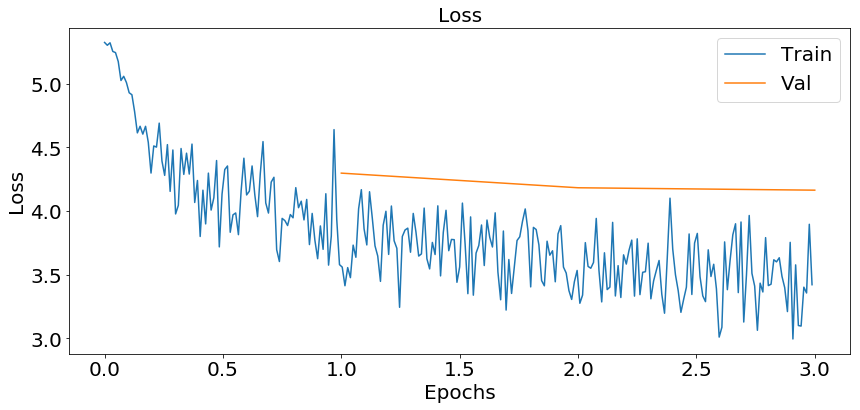

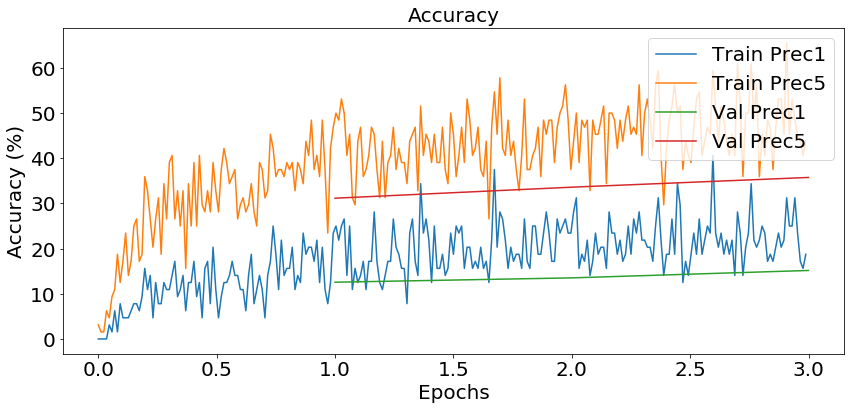

In [67]:
filename = "/home/shared/TRN-pytorch/log/multiscale-LSTM-NS5-BS64-alldata-sharedweights/2018-06-03-20-15-32/TRN_moments_RGB_BNInception_TRNmultiscale_segment5.csv"
result_df, test_df = plot_loss_acc(filename)

Before running these cells, you must run the test_model script to generate the appropriate CSV!

In [ ]:
output_csv = "/home/shared/TRN-pytorch/output/TRN_moments_RGB_BNInception_TRN_segment3_best.csv"
df, prec1_accuracy = plot_accuracy_by_class(output_csv)

In [ ]:
heatmap_df = plot_heatmap(df)